# Assigning Neighborhoods

In [45]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.cluster

In [9]:
df = pd.read_csv("nyc_taxi/data/train_trim_1.csv")

In [12]:
from shapely.geometry import Point, Polygon
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(df['pickup_longitude'],df['pickup_latitude'])]
gps = gpd.GeoDataFrame(df,crs=crs, geometry=geometry)

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [15]:
gpsshape = gpd.read_file("nyc_taxi/data/taxi_zones.shp")

In [16]:
gpsshape.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

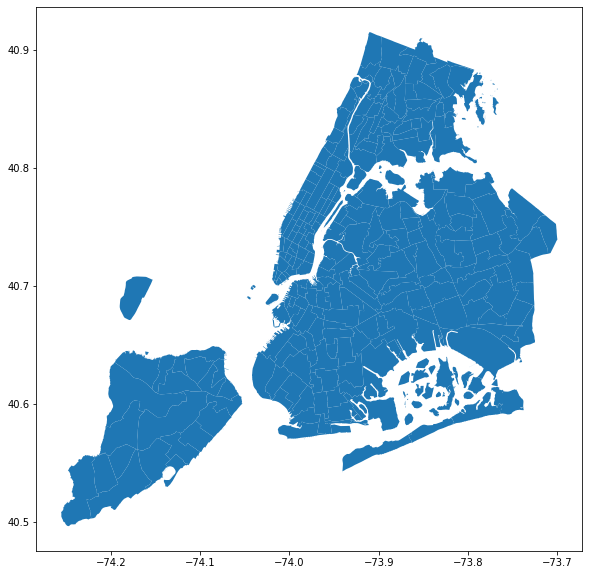

In [29]:
# set the axis to refer the correct lat and long,
gpsshape = gpsshape.to_crs(epsg=4326).plot(figsize=(20,10))

In [ ]:
# likely new york city limits
# we can stick to limits of this map

# for latitude  = 40.45 min, 50.0 max
# for longitude = -74.4 min, -73.7 max


### Filtering out values that are far beyond New York City

In [67]:
df = df[(df['pickup_longitude'] > -74.4) & (df['pickup_longitude'] < -73.7) &
       (df['pickup_latitude'] > 40.45) & (df['pickup_latitude'] < 50.0) &
        (df['dropoff_longitude'] > -74.4) & (df['dropoff_longitude'] < -73.7) &
       (df['dropoff_latitude'] > 40.45) & (df['dropoff_latitude'] < 50.0) ]


In [68]:
df.shape

(1449666, 17)

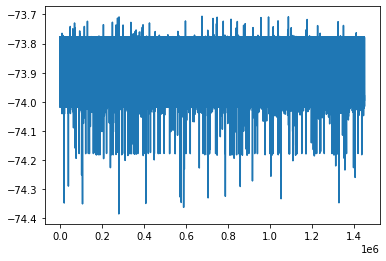

In [69]:
#trimming dataset based on unreal values of latitude and longitude
df['pickup_longitude'].plot()

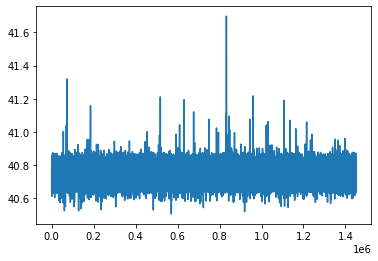

In [70]:
df['pickup_latitude'].plot()

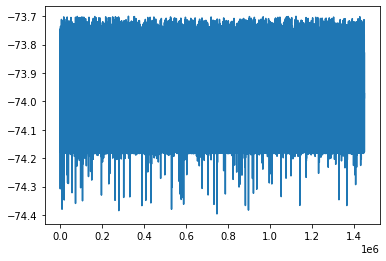

In [71]:
df['dropoff_longitude'].plot()

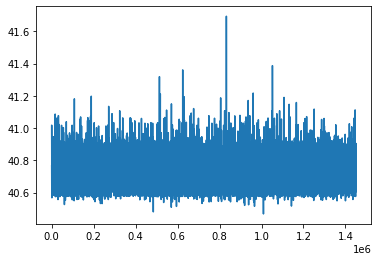

In [72]:
df['dropoff_latitude'].plot()

In [76]:
from shapely.geometry import Point, Polygon
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(df['pickup_longitude'],df['pickup_latitude'])]
df = gpd.GeoDataFrame(df,crs=crs, geometry=geometry)

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Text(0.5, 1.0, 'NYC taxi activity')

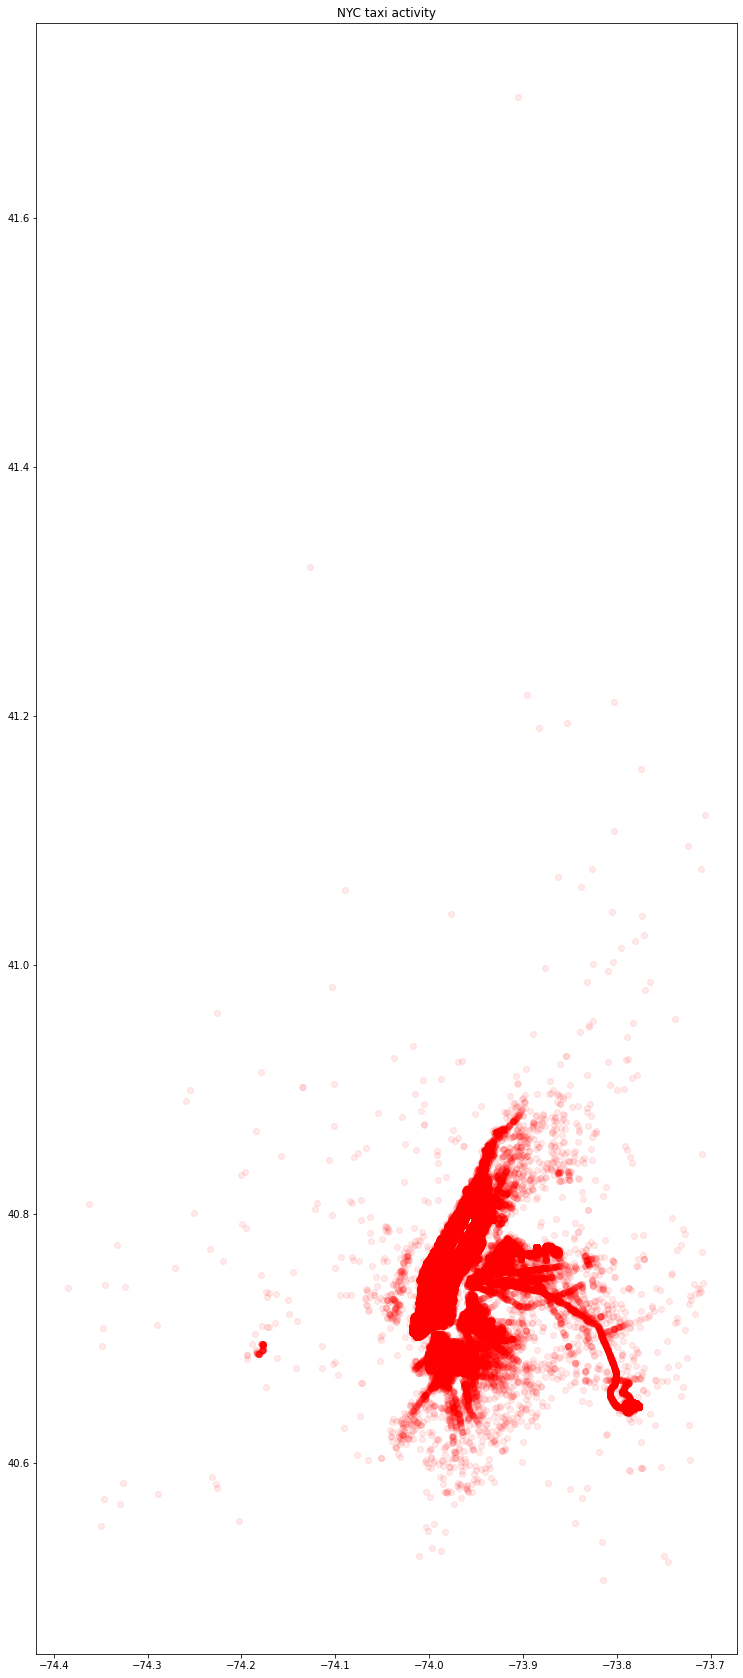

In [79]:
fig, ax = plt.subplots(figsize=(40,30))
gpsshape.plot(ax=ax,color='blue')
df.plot(ax=ax,alpha=0.085,color="red") 
ax.set_title('NYC taxi activity')

In [80]:
nbhd = pd.read_csv("nyc_taxi/data/neighborhoods.csv")

In [81]:
nbhd.head()

,neighborhood,longitude,latitude
0,Upper Manhattan,-73.944764,40.824048
1,Marble Hill,-73.910263,40.876117
2,Inwood,-73.921202,40.867715
3,Fort George,-73.933043,40.859032
4,Washington Heights,-73.939355,40.841708


In [82]:
subset = df[['id', 'pickup_longitude', 'pickup_latitude']]

In [83]:
ss = []
assignments = {}
temp = np.asmatrix(subset[['pickup_longitude', 'pickup_latitude']])

In [84]:
Krange = list(range(2, 11))



for K in Krange:
     
    model = sklearn.cluster.KMeans(n_clusters=K, random_state = 42)
    assigned_cluster = model.fit_predict(temp)
    centers = model.cluster_centers_
    ss.append(model.inertia_)
    assignments[str(K)] = assigned_cluster

Text(0, 0.5, 'Sum of Squares')

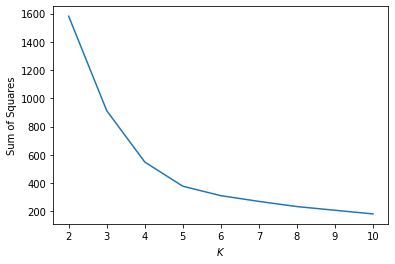

In [85]:
#looks like 4 is the optimum number of clusters

plt.plot(Krange, ss)
 
plt.xlabel("$K$")
plt.ylabel("Sum of Squares")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0, 0.5, 'Count')

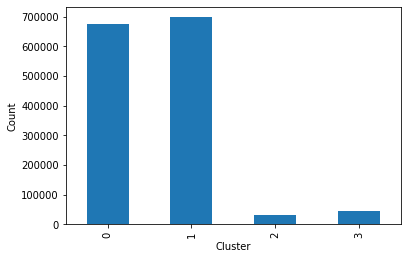

In [88]:
model = sklearn.cluster.KMeans(n_clusters=4)
subset['kmeans_cluster'] = model.fit_predict(temp)
subset.kmeans_cluster.value_counts().sort_index().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Count')

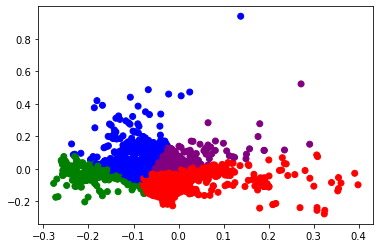

In [89]:
import sklearn.decomposition
import matplotlib.colors
 
model = sklearn.cluster.KMeans(n_clusters=4)

cluster_assignments = model.fit_predict(temp)


cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue',  'purple'])

pca = sklearn.decomposition.PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(temp))
plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap)

In [91]:
subset.head()

,id,pickup_longitude,pickup_latitude,kmeans_cluster
0,id2875421,-73.982155,40.767937,1
1,id2377394,-73.980415,40.738564,0
2,id3858529,-73.979027,40.763939,1
3,id3504673,-74.010040,40.719971,0
4,id2181028,-73.973053,40.793209,1


In [92]:
nbhd.head()

,neighborhood,longitude,latitude
0,Upper Manhattan,-73.944764,40.824048
1,Marble Hill,-73.910263,40.876117
2,Inwood,-73.921202,40.867715
3,Fort George,-73.933043,40.859032
4,Washington Heights,-73.939355,40.841708


In [93]:
#this is not exactly what I was going for
#I just want to use the cluster centers of the nbhd dataset to classify the values in df

In [97]:
df.to_csv('nyc_taxi/data/train_trim_2.csv')